In [55]:
import numpy as np

In [56]:
class MLP:
    """
    n_hidden : 隐藏层数量
    l2 : 距离度量,正则化的惩罚力度
    epoch : 训练轮数，每个样本都使用一次，记为一轮
    eta : 学习率
    shuffle : 每轮训练时，是否对样本进行洗牌
    batch_size : 每个批次的样本数量
    seed ： 随机种子
    """

    def __init__(self,n_hidden = 32,l2 = 0,epoch = 100,eta = 0.01,shuffle = False,batch_size = 1,seed = None):
        self.n_hidden = n_hidden
        self.l2 = l2
        self.epoch = epoch
        self.eta = eta
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.random = np.random.RandomState(seed)

        # 用来储存每轮训练结束后的模型
        # cost:损失函数的值
        # train_acc: 训练集的正确率
        # valid_acc: 验证集的正确率
        self.eval_ = {'cost':[],'train_acc':[],'valid_acc':[]}

    # 将样本标签转化为one-hot编码的形式，便于计算损失
    @staticmethod
    def _one_hot(y):
        n_classes = np.unique(y).shape[0]
        one_hot = np.zeros(shape = (y.shape[0],n_classes))
        for idx,val in enumerate(y):
            one_hot[idx,val]=1
        return one_hot
    
    # 计算激活函数的导数
    @staticmethod
    def _sigmoid_derivative(z):
        return z*(1-z)
    
    # 计算激活函数
    @staticmethod
    def _sigmoid_forword(z):
        return 1/(1+np.exp(-z))
    
    # 计算前向传播的方法
    def _forword(self,x):
        # 计算净输入 
        z_h = np.dot(x,self.w_h)+self.b_h
        # 计算隐藏层激活输出
        a_h = MLP._sigmoid_forword(z_h)
        # 计算输出层的净输入
        z_out= np.dot(a_h,self.w_out)+self.b_out
        # 计算输出层的激活输出
        a_out = MLP._sigmoid_forword(z_out)
        return z_h,a_h,z_out,a_out
    
    # 损失函数
    def _compute_cost(self,y_enc,output):
        # y_enc:经过one_hot编码后的真实值
        # output:模型输出的预测值
        L2_term = self.l2*(np.sum(self.w_h**2)+np.sum(self.w_out**2))
        # output 的概率可能为0或1，此时对对数会产生错误，可以加上一个很小的值，避免错误
        tiny = 1e-5
        term1 = -y_enc*np.log(output+tiny)
        term2 = -(1-y_enc)*np.log(1-output+tiny)
        cost = np.sum(term1 + term2)+L2_term
        return cost
    
    # 预测函数
    def predict(self,x):
        z_h,a_h,z_out,a_out = self._forword(x)
        return np.argmax(z_out,axis=1)

    def fit(self,x_train,y_train,x_valid,y_valid):
        # x_train ：训练集
        # x_valid : 验证集
        
        # 计算输出神经元数量，在分类任务中，y有几个类别，就有几个输出神经元 
        n_output = np.unique(y_train).shape[0]
        # 计算特征数量，输入层神经元数量
        n_fraturns = x_train.shape[1]

        # 定义隐藏层权重与偏置
        self.w_h = self.random.normal(loc = 0,scale = 0.1,size=(n_fraturns,self.n_hidden))
        self.b_h = np.zeros(shape = self.n_hidden)

        # 定义输出层权重与偏置
        self.w_out = self.random.normal(loc = 0,scale = 0.1,size=(self.n_hidden,n_output))
        self.b_out= np.zeros(shape = n_output)

        # 将y_train和y_validy_valid转化为one_hot编码
        y_train_enc= self._one_hot(y_train)

        # 开始拟合
        for i in range(self.epoch):

            index = np.arange(x_train.shape[0])
            # 是否对样本进行随机处理
            if self.shuffle:
                self.random.shuffle(index)
            # 小批量样本进行梯度计算
            for start_idx in range(0,index.shape[0]-self.batch_size+1,self.batch_size):
                # 每个批次获取的样本索引
                batch_idx = index[start_idx:start_idx+self.batch_size]
                # 计算前向传播
                z_h,a_h,z_out,a_out = self._forword(x_train[batch_idx])

                # 计算输出层梯度
                out_error = a_out - y_train_enc[batch_idx] # shape = (1，3) 
                out_delta = out_error * MLP._sigmoid_derivative(a_out) # shape = (1，3)
                grad_w_out = np.dot(a_h.T,out_delta) # shape = (32，3)
                grad_b_out = np.sum(out_delta,axis=0)

                # 计算隐藏层梯度
                h_error = np.dot(out_delta,self.w_out.T) # shape = (1，32)
                h_delta = h_error*MLP._sigmoid_derivative(a_h) # shape = (1，32)
                grad_w_h = np.dot(x_train[batch_idx].T,h_delta) # shape = (5，32)
                grad_b_h = np.sum(h_delta,axis=0)

                # 计算最终梯度
                delta_w_h = grad_w_h+self.l2*self.w_h
                delta_b_h = grad_b_h

                delta_w_out = grad_w_out+self.l2*self.w_out
                delta_b_out = grad_b_out

                # 梯度更新
                self.w_h -= self.eta*delta_w_h
                self.b_h -= self.eta*delta_b_h
                self.w_out -= self.eta*delta_w_out
                self.b_out -= self.eta*delta_b_out

            # 在每一轮训练结束，查看训练效果，首先进行前向传报
            z_h,a_h,z_out,a_out = self._forword(x_train)
            # 然后计算损失
            cost = self._compute_cost(y_enc=y_train_enc,output=a_out)
            # 对训练集以及验证集进行预测，计算在训练集和验证集上的正确率
            y_trian_pred = self.predict(x_train)
            y_valid_pred = self.predict(x_valid)

            train_acc = np.sum(y_trian_pred == y_train)/x_train.shape[0]
            valid_acc = np.sum(y_valid_pred == y_valid)/x_valid.shape[0]

            # 将评估结果存放在字典中
            self.eval_['cost'].append(cost)
            self.eval_['train_acc'].append(train_acc)
            self.eval_['valid_acc'].append(valid_acc)
        return self

In [62]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

x,y = make_classification(n_samples=1000,n_features=5,n_classes=3,random_state=0,n_informative=3)
x_train,x_valid,y_train,y_valid = train_test_split(x,y,test_size=0.3,random_state=0)

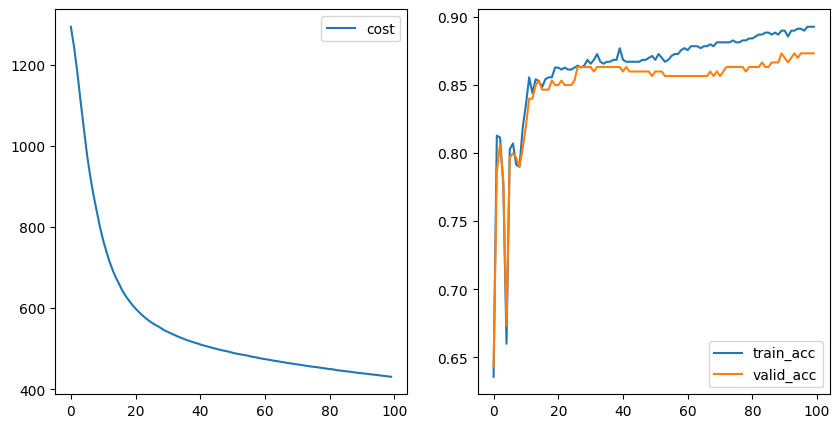

In [61]:
m = MLP(batch_size=100,shuffle=True)
m.fit(x_train,y_train,x_valid,y_valid)

fig,ax = plt.subplots(1,2,figsize = (10,5))

ax[0].plot(m.eval_['cost'],label = 'cost')
ax[0].legend()
ax[1].plot(m.eval_['train_acc'],label = 'train_acc')
ax[1].plot(m.eval_['valid_acc'],label = 'valid_acc')
ax[1].legend()